<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Homeworks/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
March 3, 2025

#Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can dounload files directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path). **If you use this repo, use 'Claims.csv' instead of 'Claims_Y1.csv'**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. (1pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [3]:
path = 'https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/'

In [4]:
m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [5]:
m.info()
print()
m.shape

<class 'pandas.core.frame.DataFrame'>
Index: 113000 entries, 14723353 to 81827173
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   AgeAtFirstClaim  107247 non-null  object
 1   Sex              95448 non-null   object
dtypes: object(2)
memory usage: 2.6+ MB



(113000, 2)

In [6]:
claims=pd.read_csv(path+'Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [7]:
claims.info()
print()
claims.shape

<class 'pandas.core.frame.DataFrame'>
Index: 2668990 entries, 42286978 to 57805129
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ProviderID             float64
 1   Vendor                 float64
 2   PCP                    float64
 3   Year                   object 
 4   Specialty              object 
 5   PlaceSvc               object 
 6   PayDelay               object 
 7   LengthOfStay           object 
 8   DSFS                   object 
 9   PrimaryConditionGroup  object 
 10  CharlsonIndex          object 
 11  ProcedureGroup         object 
 12  SupLOS                 int64  
dtypes: float64(3), int64(1), object(9)
memory usage: 285.1+ MB



(2668990, 13)

In [8]:
claims.isnull().sum()

,0
ProviderID,16264
Vendor,24856
PCP,7492
Year,0
Specialty,8405
PlaceSvc,7632
PayDelay,0
LengthOfStay,2597392
DSFS,52770
PrimaryConditionGroup,11410


In [9]:
days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


In [10]:
days2.info()
print()
days2.shape

<class 'pandas.core.frame.DataFrame'>
Index: 76038 entries, 24027423 to 21964521
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ClaimsTruncated  76038 non-null  int64
 1   DaysInHospital   76038 non-null  int64
dtypes: int64(2)
memory usage: 1.7 MB



(76038, 2)

In [11]:
days2.isnull().sum()

,0
ClaimsTruncated,0
DaysInHospital,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the Age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [12]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-12-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [13]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [14]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


In [15]:
print(y)
print()
print(y.shape)

[0 0 1 ... 0 0 0]

(76038,)


In [16]:
X.info()
print()
X.shape

<class 'pandas.core.frame.DataFrame'>
Index: 76038 entries, 24027423 to 21964521
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ClaimsTruncated  76038 non-null  int64
 1   CharlsonIndex    76038 non-null  int64
 2   LengthOfStay     76038 non-null  int64
 3   AgeAtFirstClaim  76038 non-null  int64
dtypes: int64(4)
memory usage: 4.9 MB



(76038, 4)

## 2. (3pt) Add to the features columm `Sex`

In [17]:
# Add the feature Sex from the Members data (m) to the feature matrix X on the correct MemberID
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.
from sklearn.model_selection import train_test_split

# Assume X and y are your features and labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)  # First split (50% train, 50% temp)

# Split the temporary set into validation and test sets (each 25%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Train set size: 38019
Validation set size: 19009
Test set size: 19010


In [20]:
X_train.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
78411929,0,0,1,10,M
98508908,0,0,0,60,M
70301481,0,1,0,60,NaN
56730824,0,0,0,0,M
24399252,1,5,1,80,NaN


##4. (2pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set. (Don't forget parameter `reminder`)

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [22]:
oneHE = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')

In [23]:
colTransformer = ColumnTransformer([('one', oneHE, ['Sex'])], remainder='passthrough')

In [24]:
# colTransformer.fit_transform(X_train)

In [25]:
# X_train_hot = pd.DataFrame(colTransformer.fit_transform(X_train), columns=colTransformer.get_feature_names_out())
# X_test_hot = pd.DataFrame(colTransformer.transform(X_test), columns=colTransformer.get_feature_names_out())

In [26]:
# X_train.head()

In [27]:
# X_train_hot.head()

In [28]:
# pd.DataFrame(colTransformer.transform(X_train), columns=colTransformer.get_feature_names_out()).head()

In [29]:
# The ColumnTransformer will create automatically 'OneHot__Sex_nan' column afer fitting this transformer on the Train set.
# X_train_hot = pd.DataFrame(colTransformer.fit_transform(X_train), columns=colTransformer.get_feature_names_out())
# X_test_hot = pd.DataFrame(colTransformer.transform(X_test), columns=colTransformer.get_feature_names_out())

In [30]:
# X_train_hot.head()

## 5. (3pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [33]:
# Create a pipeline for training logistic regression. It should include transformation, scaling, and model.
pipeline = Pipeline([
    ('colTransformer', colTransformer),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

In [34]:
# And fit it on the Training set
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('colTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay

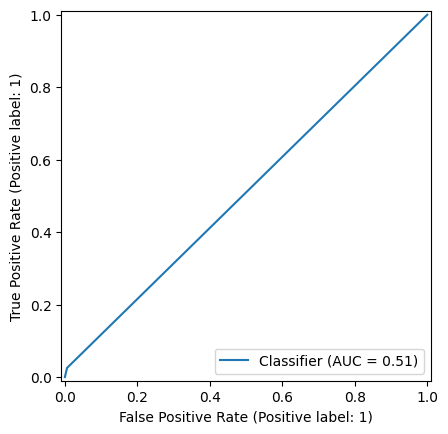

In [43]:
# Plot ROC-AUC FROM Predictions
RocCurveDisplay.from_predictions(y_val, pipeline.predict(X_val))

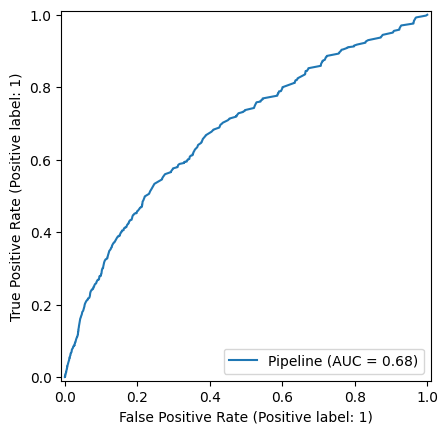

In [44]:
# Plot ROC-AUC FROM Estimator
RocCurveDisplay.from_estimator(pipeline, X_val, y_val)

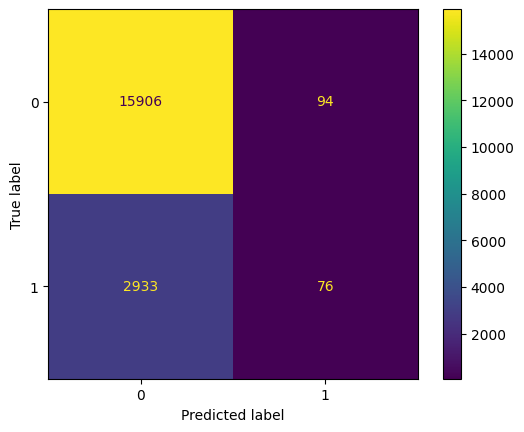

In [45]:
# Plot Confusion Matrix FROM Predictions
ConfusionMatrixDisplay.from_predictions(y_val, pipeline.predict(X_val))

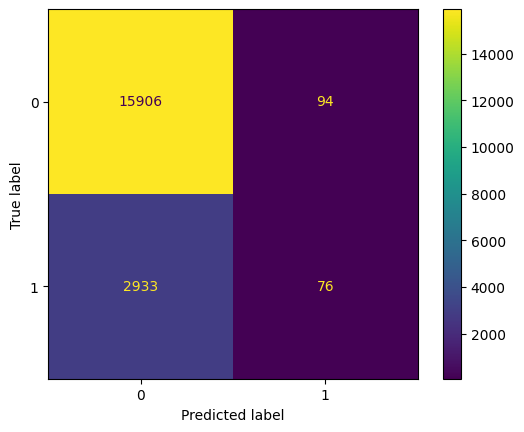

In [46]:
# Plot Confusion Matrix FROM ESTIMATOR
ConfusionMatrixDisplay.from_estimator(pipeline, X_val, y_val)

In [47]:
# Report the Recall value.
recall_score(y_val, pipeline.predict(X_val))

0.025257560651379195

## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC (it won't change because the model stays unchanged) and Confusion Matrix. Report the Recall value.

In [146]:
# Use .predict_proba to get the values in the interval  [0, 1]  instead of the classes 0 or 1.
y_val_pred_proba = pipeline.predict_proba(X_val)[:,1]

In [148]:
# Choose the threshold, such that recall on the Validation set is  >0.5  (Think about this as the insuarance company's requirement.)
threshold = 0.12
y_val_pred_binary = (y_val_pred_proba >= threshold).astype(int)

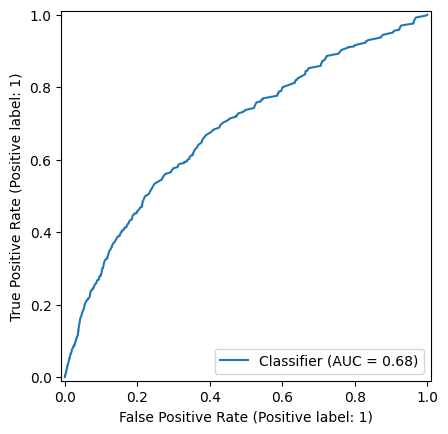

In [149]:
RocCurveDisplay.from_predictions(y_val, y_val_pred_proba)

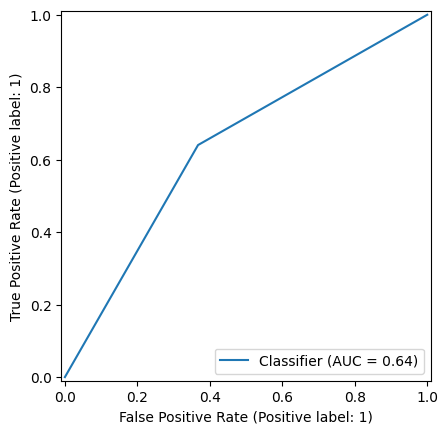

In [150]:
RocCurveDisplay.from_predictions(y_val, y_val_pred_binary)

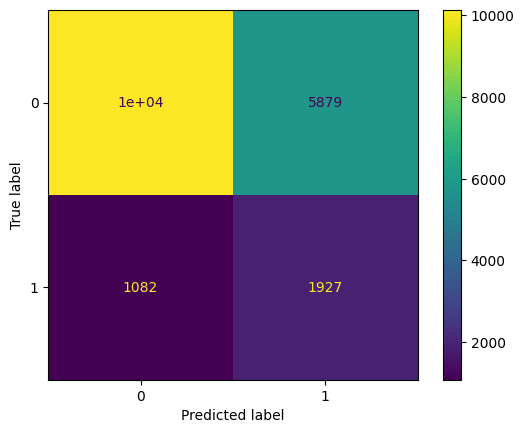

In [151]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_binary)

In [152]:
# Report the Recall value.
recall_score(y_val, y_val_pred_binary)

0.6404120970422067

## 8. (2 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

In [160]:
# Use .predict_proba to get the values in the interval  [0, 1]  instead of the classes 0 or 1.
y_test_pred_proba = pipeline.predict_proba(X_test)[:,1]

In [161]:
# Choose the threshold, such that recall on the Validation set is  >0.5  (Think about this as the insuarance company's requirement.)
threshold = 0.12
y_test_pred_binary = (y_test_pred_proba >= threshold).astype(int)

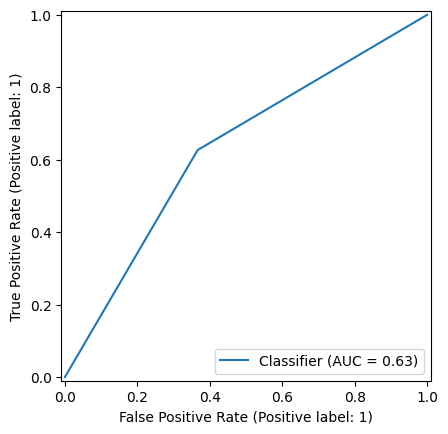

In [162]:
# Plot ROC-AUC on the Test set.
RocCurveDisplay.from_predictions(y_test, y_test_pred_binary)

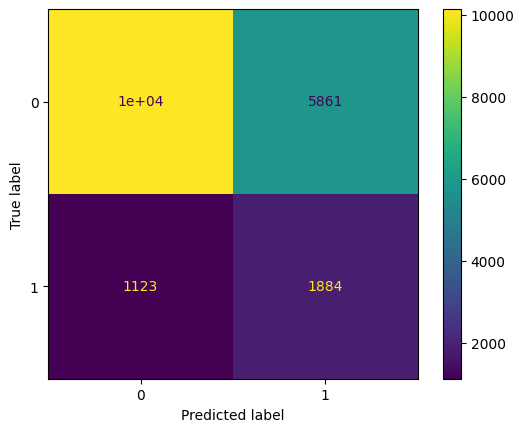

In [163]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_binary)

In [164]:
# Report the Recall value.
recall_score(y_test, y_test_pred_binary)

0.6265380778184236

## 9. (2pt) Which features are more important?

In [166]:
# Get the trained logistic regression model from the pipeline
logreg_model = pipeline.named_steps['model']

In [167]:
# Get the coefficients (feature importance)
feature_importance = logreg_model.coef_[0]

In [168]:
# Get feature names after the ColumnTransformer
feature_names = pipeline.named_steps['colTransformer'].get_feature_names_out()

# Create a DataFrame to associate feature names with importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance (absolute value for magnitude)
feature_importance_df = feature_importance_df.sort_values('Importance', key=abs, ascending=False)

# Display the DataFrame
print(feature_importance_df)

                      Feature  Importance
1                one__Sex_nan    0.312709
3    remainder__CharlsonIndex    0.230368
2  remainder__ClaimsTruncated    0.186774
0                  one__Sex_M   -0.119263
4     remainder__LengthOfStay    0.101800
5  remainder__AgeAtFirstClaim    0.068977
